<a href="https://colab.research.google.com/github/Hagar-zakaria/Customer-Lifetime-Value-CLV-Prediction-Model-Detailed-Report/blob/main/Car_CLV_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Preparation

# **Import Necessary Libraries**

In [ ]:
# Install required libraries
!pip install Faker scikit-learn pandas numpy xgboost

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import random
from datetime import datetime
from faker import Faker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

### **Explanation of Each Import:**

1. **`import numpy as np`**  
   - **Purpose**: Numpy is used for handling numerical operations, arrays, and matrices efficiently.

2. **`import pandas as pd`**  
   - **Purpose**: Pandas is used to create and manipulate data in DataFrames, making it easy to handle structured data.

3. **`import random`**  
   - **Purpose**: Used for generating random values (like age, spending, or categories) to create synthetic data.

4. **`from datetime import datetime`**  
   - **Purpose**: Handles date and time-related operations, such as calculating recency from the last purchase date.

5. **`from faker import Faker`**  
   - **Purpose**: Used to generate realistic fake data, such as names, cities, and other customer information.

6. **`from sklearn.model_selection import train_test_split, GridSearchCV`**  
   - **`train_test_split`**: Splits data into training and testing sets for model evaluation.  
   - **`GridSearchCV`**: Performs hyperparameter tuning to find the best parameters for the model.

7. **`from sklearn.preprocessing import StandardScaler, OneHotEncoder`**  
   - **`StandardScaler`**: Standardizes numerical data to ensure all features have the same scale.  
   - **`OneHotEncoder`**: Converts categorical variables into binary (one-hot) encoded columns.

8. **`from sklearn.compose import ColumnTransformer`**  
   - **Purpose**: Applies different preprocessing steps to numerical and categorical features in the same pipeline.

9. **`from sklearn.pipeline import Pipeline`**  
   - **Purpose**: Combines preprocessing steps and model fitting into a single pipeline for efficiency.

10. **`from sklearn.ensemble import RandomForestRegressor`**  
    - **Purpose**: A regression model that builds multiple decision trees and averages their results to make predictions.

11. **`from xgboost import XGBRegressor`**  
    - **Purpose**: A high-performance, gradient-boosted decision tree algorithm used for regression tasks.

12. **`from sklearn.metrics import mean_absolute_error, mean_squared_error`**  
    - **`mean_absolute_error (MAE)`**: Measures the average magnitude of prediction errors.  
    - **`mean_squared_error (MSE)`**: Measures the average squared difference between actual and predicted values; RMSE is the square root of this.


# 2. Data Generation & Preprocessing

In [ ]:
# Initialize Faker instance
fake = Faker()

In [ ]:
# Define categorical feature lists
vehicle_types = ['Car', 'Truck', 'Motorcycle', 'Bus']
usage_types = ['Personal', 'Commercial']
purchase_channels = ['Dealership', 'Direct Sales', 'Online']

In [ ]:
# Use the latest possible purchase date as the reference
reference_date = datetime(2023, 12, 28)

# Re-initialize data list and unique records tracking
data = []
unique_records = set()

# Generate synthetic data points (e.g., 5000 customers)
num_customers = 5000

for _ in range(num_customers):
    customer_id = fake.unique.uuid4()
    age = random.randint(18, 70)
    gender = random.choice(['Male', 'Female'])
    region = fake.city() + " " + fake.state_abbr()
    vehicle_type = random.choice(vehicle_types)
    usage_type = random.choice(usage_types)
    purchase_channel = random.choice(purchase_channels)
    num_transactions = random.randint(1, 20)
    total_spend = round(random.uniform(5000, 500000), 2)
    last_purchase_date = datetime(2023, random.randint(1, 12), random.randint(1, 28))
    warranty_status = random.choice(['Active', 'Expired'])
    avg_maintenance_spend = round(random.uniform(500, 10000), 2)
    time_since_last_service = random.randint(0, 365)

    # Ensure unique records
    while (customer_id, total_spend, region) in unique_records:
        customer_id = fake.unique.uuid4()
        total_spend = round(random.uniform(5000, 500000), 2)
        region = fake.city() + " " + fake.state_abbr()

    unique_records.add((customer_id, total_spend, region))

    # Derived fields
    aov = total_spend / num_transactions if num_transactions > 0 else 0
    recency = (reference_date - last_purchase_date).days
    frequency = num_transactions

    # Append data to the list
    data.append([
        customer_id, age, gender, region, vehicle_type, usage_type, purchase_channel,
        last_purchase_date, total_spend, frequency, recency, aov, warranty_status,
        avg_maintenance_spend, time_since_last_service
    ])

# Convert data to DataFrame
df = pd.DataFrame(data, columns=[
    'CustomerID', 'Age', 'Gender', 'Region', 'VehicleType', 'UsageType', 'PurchaseChannel',
    'LastPurchaseDate', 'TotalSpend', 'Frequency', 'Recency', 'AverageOrderValue',
    'WarrantyStatus', 'AvgMaintenanceSpend', 'TimeSinceLastService'
])

# Drop duplicates (if any)
df = df.drop_duplicates()

# Preview the updated DataFrame
df.head()


,CustomerID,Age,Gender,Region,VehicleType,UsageType,PurchaseChannel,LastPurchaseDate,TotalSpend,Frequency,Recency,AverageOrderValue,WarrantyStatus,AvgMaintenanceSpend,TimeSinceLastService
0,e3e402c1-cae7-47ef-b41e-819b44b35893,49,Male,East Frederick AL,Car,Personal,Direct Sales,2023-12-12,281065.39,12,16,23422.12,Active,1640.00,96
1,de7464d2-838a-416a-9b92-e3cbfde6275d,64,Male,Stevefurt LA,Bus,Commercial,Dealership,2023-06-17,216548.30,6,194,36091.38,Active,3747.78,300
2,79645eac-b035-4c1a-9948-8308b8ab4a4c,40,Female,Frazierchester VA,Truck,Personal,Online,2023-01-20,59419.53,4,342,14854.88,Active,6052.40,348
3,9837417f-0e59-48a3-a6a8-9b27cc8acf5d,61,Male,West Jenniferstad MP,Bus,Commercial,Dealership,2023-06-20,360378.41,1,191,360378.41,Expired,5222.89,130
4,22811b70-1f33-4252-941b-dfdb88053313,55,Male,South Marcus AS,Truck,Commercial,Direct Sales,2023-12-11,183299.35,3,17,61099.78,Expired,758.50,185


1. **data:** An empty list to store the generated customer records.

2. **unique_records:** A set to keep track of unique combinations of attributes to avoid duplicate records.

3. **Defines the number of customers** (5,000) to be generated.

4. **Generate Data for Each Customer:**:
- **customer_id**: A unique identifier for each customer using Faker.  
- **age**: Randomly assigned between 18 and 70 years.  
- **gender**: Randomly selected as either 'Male' or 'Female'.  
- **region**: A random city and state abbreviation using Faker.  
- **vehicle_type**: Randomly selected from predefined vehicle types.  
- **usage_type**: Randomly selected as either 'Personal' or 'Commercial'.  
- **purchase_channel**: Randomly chosen from various sales channels.  
- **num_transactions**: Randomly assigned between 1 and 20.  
- **total_spend**: A random total spending amount between 5,000 and 500,000.  
- **last_purchase_date**: A random date in 2023.  
- **warranty_status**: Randomly assigned as 'Active' or 'Expired'.  
- **avg_maintenance_spend**: Random maintenance spend between 500 and 10,000.  
- **time_since_last_service**: Randomly assigned between 0 and 365 days.  

5. **Ensure Unique Records:** Checks if the generated combination of customer_id, total_spend, and region already exists. If it does, regenerates these values until a unique combination is found. Adds the unique combination to the unique_records set.

6. **Calculate Derived Fields:**
- **aov**: Calculates the Average Order Value (AOV) by dividing `total_spend` by `num_transactions`. If there are no transactions, AOV is set to 0.  
- **recency**: Calculates the number of days since the last purchase.  
- **frequency**: Sets the total number of transactions made by the customer.  

7. **Converts the data list** into a Pandas DataFrame with appropriate column names.

8. **Drop Duplicates:**  Ensures there are no duplicate rows in the DataFrame.

9. **Preview the DataFrame:** Displays the first few rows of the DataFrame to verify the generated data.






**Feature Engineering  Advanced**

Create additional derived fields to capture more meaningful insights about customers.

In [ ]:
df['CustomerAgeGroup'] = pd.cut(df['Age'], bins=[18, 30, 50, 70], labels=['Young', 'Adult', 'Senior'])
df['HighValueCustomer'] = df['TotalSpend'].apply(lambda x: 1 if x > 100000 else 0)
df['LoyalCustomer'] = df['Frequency'].apply(lambda x: 1 if x > 10 else 0)


- Create age groups to segment customers.

- Identify high-value customers based on TotalSpend.

- Identify loyal customers based on purchase frequency.

**Add Aggregated or Cohort Features**

Add cohort features such as the quarter of the year the customer purchased:

In [ ]:
df['PurchaseQuarter'] = df['LastPurchaseDate'].dt.to_period('Q')

Helps understand purchasing trends by quarter.


**Build New Target Variable (CLV Prediction)**

Calculate the future expected value of each customer based on AOV and Frequency.


In [ ]:
df['PredictedCLV'] = df['AverageOrderValue'] * df['Frequency'] * 12


 Estimate the future value assuming similar purchasing behavior continues for one year

In [ ]:
df.head()

,CustomerID,Age,Gender,Region,VehicleType,UsageType,PurchaseChannel,LastPurchaseDate,TotalSpend,Frequency,Recency,AverageOrderValue,WarrantyStatus,AvgMaintenanceSpend,TimeSinceLastService,CustomerAgeGroup,HighValueCustomer,LoyalCustomer,PurchaseQuarter,PredictedCLV
0,e3e402c1-cae7-47ef-b41e-819b44b35893,49,Male,East Frederick AL,Car,Personal,Direct Sales,2023-12-12,281065.39,12,16,23422.12,Active,1640.00,96,Adult,1,1,2023Q4,3372784.68
1,de7464d2-838a-416a-9b92-e3cbfde6275d,64,Male,Stevefurt LA,Bus,Commercial,Dealership,2023-06-17,216548.30,6,194,36091.38,Active,3747.78,300,Senior,1,0,2023Q2,2598579.60
2,79645eac-b035-4c1a-9948-8308b8ab4a4c,40,Female,Frazierchester VA,Truck,Personal,Online,2023-01-20,59419.53,4,342,14854.88,Active,6052.40,348,Adult,0,0,2023Q1,713034.36
3,9837417f-0e59-48a3-a6a8-9b27cc8acf5d,61,Male,West Jenniferstad MP,Bus,Commercial,Dealership,2023-06-20,360378.41,1,191,360378.41,Expired,5222.89,130,Senior,1,0,2023Q2,4324540.92
4,22811b70-1f33-4252-941b-dfdb88053313,55,Male,South Marcus AS,Truck,Commercial,Direct Sales,2023-12-11,183299.35,3,17,61099.78,Expired,758.50,185,Senior,1,0,2023Q4,2199592.20


**Exploratory Data Analysis (EDA) and Deep Insights**

In [ ]:
# Check for missing values
print(df.isnull().sum())

# Descriptive statistics
print(df.describe())

# Data types of each column
print(df.dtypes)

# Count of unique values in categorical columns
categorical_cols = ['Gender', 'VehicleType', 'UsageType', 'PurchaseChannel', 'WarrantyStatus']
for col in categorical_cols:
    print(f"Unique values in {col}: {df[col].unique()}")


CustomerID               0
Age                      0
Gender                   0
Region                   0
VehicleType              0
UsageType                0
PurchaseChannel          0
LastPurchaseDate         0
TotalSpend               0
Frequency                0
Recency                  0
AverageOrderValue        0
WarrantyStatus           0
AvgMaintenanceSpend      0
TimeSinceLastService     0
CustomerAgeGroup        93
HighValueCustomer        0
LoyalCustomer            0
PurchaseQuarter          0
PredictedCLV             0
dtype: int64
          Age            LastPurchaseDate  TotalSpend  Frequency  Recency  \
count 5000.00                        5000     5000.00    5000.00  5000.00   
mean    44.20  2023-07-01 00:06:37.440000   252589.88      10.55   180.00   
min     18.00         2023-01-01 00:00:00     5113.79       1.00     0.00   
25%     31.00         2023-04-03 00:00:00   129832.56       6.00    92.00   
50%     44.00         2023-07-02 00:00:00   253090.53      11.

## **Insights from Descriptive Statistics**
1. **Age**:
 - Average customer age is 44 years, with most customers between **31 and 58 years**.
 - The youngest customer is **18 years**, and the oldest is **70 years**.

2. **Spending Patterns**:
 - Average **TotalSpend** is around **254,312**, with a wide range from **5,054** to **499,908**.
 - High variability in spending, indicated by the **standard deviation** of 144,055.

3. **Recency**:
 - The **average recency** is **182.6 days**, with most customers making a purchase within the past **272 days**.
 - The minimum recency is **3 days**, indicating some customers purchased very recently.

4. **Frequency**:
 - Customers typically made around **10 transactions**, with some making up to **20 transactions**.
 - The variability in purchase frequency suggests differences in customer engagement.

5. **Customer Lifetime Value (CLV)**:
 - **Predicted CLV** averages around **3,051,747**, with high variability across customers.
 - Some customers have low predicted values (**60,654**), while others reach up to nearly **6 million**.

---

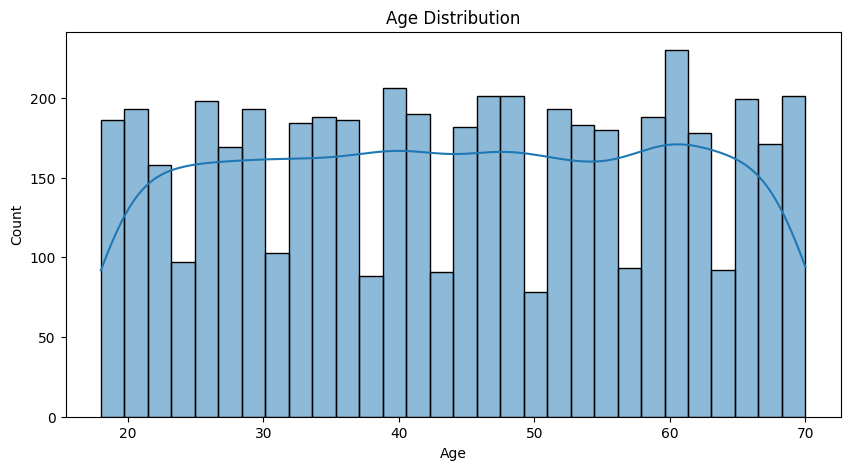

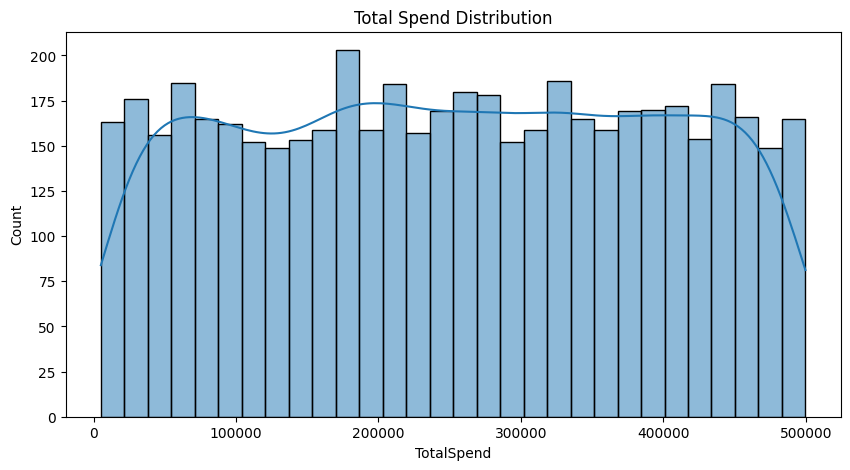

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Age Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

# Total Spend Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['TotalSpend'], bins=30, kde=True)
plt.title('Total Spend Distribution')
plt.show()


# **Exploratory Data Analysis: Visualizing Key Distributions**

## **1. Age Distribution**
- **Observation**:
  - The age distribution shows a relatively even spread across different age groups, with peaks around ages **30** and **70**.
  - The dataset includes customers between **18 and 70 years**, with a balanced count across most age ranges.
  


---

## **2. Total Spend Distribution**
- **Observation**:
  - Total spending is distributed across a wide range, with the **highest density** of spending between **100,000 and 500,000**.
  - A slight increase is observed towards the upper end, where a significant number of customers spend **above 400,000**.



---




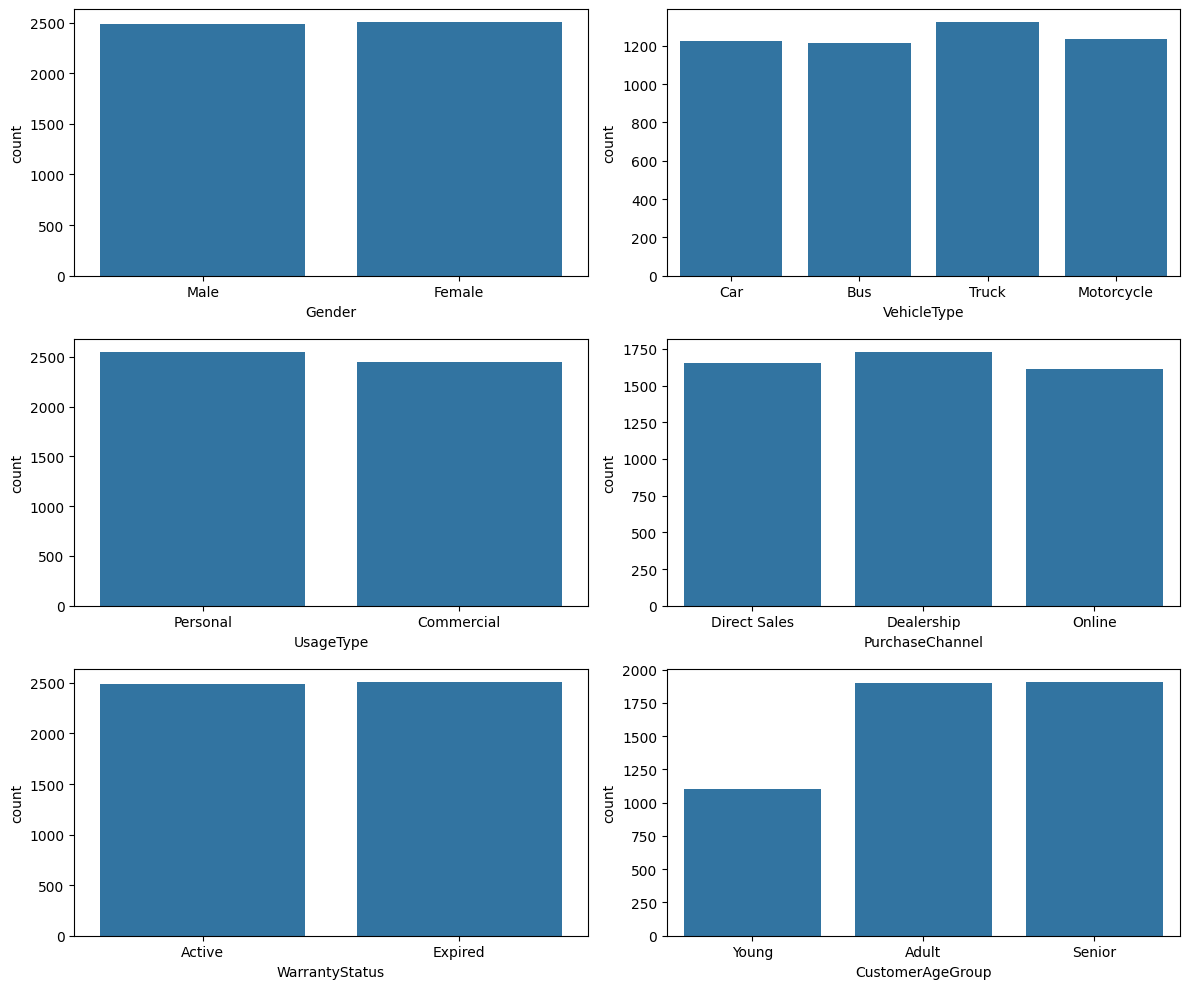

In [ ]:
# Plot distribution of categorical features
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
sns.countplot(data=df, x='Gender', ax=axes[0, 0])
sns.countplot(data=df, x='VehicleType', ax=axes[0, 1])
sns.countplot(data=df, x='UsageType', ax=axes[1, 0])
sns.countplot(data=df, x='PurchaseChannel', ax=axes[1, 1])
sns.countplot(data=df, x='WarrantyStatus', ax=axes[2, 0])
sns.countplot(data=df, x='CustomerAgeGroup', ax=axes[2, 1])
fig.tight_layout()
plt.show()


# 3.**Analyzing Customer Segments by High and Loyal Customers**

<ipython-input-64-3c0ed3a53c59>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='HighValueCustomer', palette='Set2')


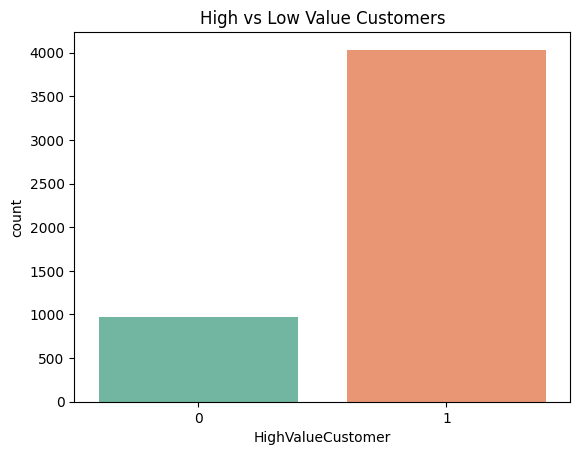

<ipython-input-64-3c0ed3a53c59>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='LoyalCustomer', y='TotalSpend', palette='Set3')


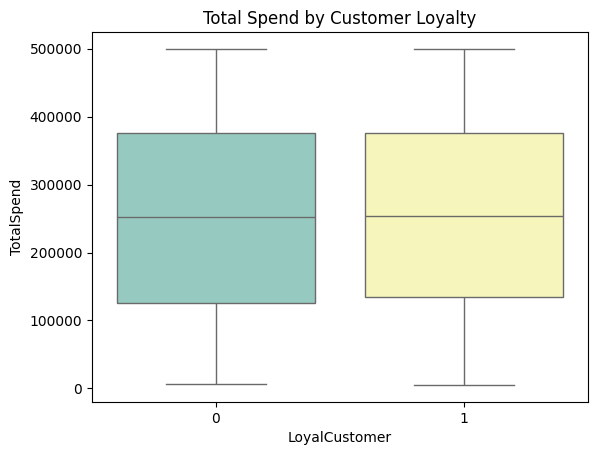

In [ ]:
# Count plot: High vs Low Value Customers
sns.countplot(data=df, x='HighValueCustomer', palette='Set2')
plt.title('High vs Low Value Customers')
plt.show()

# Box plot: Total Spend for Loyal vs Non-loyal Customers
sns.boxplot(data=df, x='LoyalCustomer', y='TotalSpend', palette='Set3')
plt.title('Total Spend by Customer Loyalty')
plt.show()



### 1. High vs Low Value Customers
- **High-Value Customers (1):** ~4000 customers, indicating most spend above the threshold (e.g., 100,000 units).
- **Low-Value Customers (0):** ~1000 customers, representing a smaller proportion of low spenders.
- **Insight:** A majority of customers contribute significantly, reflecting a healthy customer base with high spending behavior.

### 2. Total Spend by Customer Loyalty (Box Plot)
- **Non-loyal Customers (0):**
  - **Median Spend:** ~250,000 units  
  - **Spend Range:** 5,000 to 500,000 units  
  - **Observation:** Some high spenders despite being non-loyal, indicating potential one-time bulk purchases.

- **Loyal Customers (1):**
  - **Median Spend:** ~250,000 units with slightly less variability than non-loyal customers.

- **Insight:** Similar spending patterns across both groups suggest an opportunity to increase the average order value among loyal customers through targeted strategies.


# **4.Time-Based Analysis**

<ipython-input-65-d1bebcdbb5ac>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cohort, x='PurchaseQuarter', y='AverageSpend', palette='Blues_d')


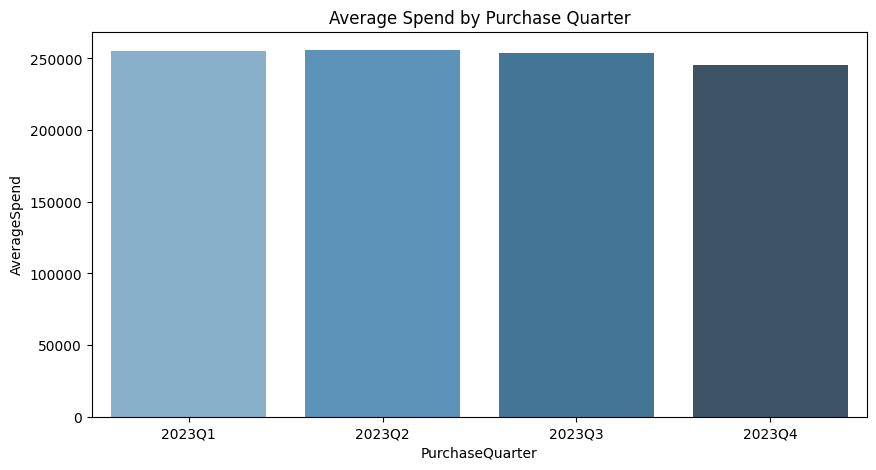

In [ ]:
# Time-based trends: Average Spend by Purchase Quarter
cohort = df.groupby('PurchaseQuarter').agg(AverageSpend=('TotalSpend', 'mean')).reset_index()

# Plot cohort analysis
plt.figure(figsize=(10, 5))
sns.barplot(data=cohort, x='PurchaseQuarter', y='AverageSpend', palette='Blues_d')
plt.title('Average Spend by Purchase Quarter')
plt.show()


- Consistent Spending Across Quarters

- The first quarter (Q1 2023) shows the highest average spend

- The consistency across quarters suggests stable customer spending behavior, without major seasonal variations



# **5.Relationship between Features and Target (CLV)**

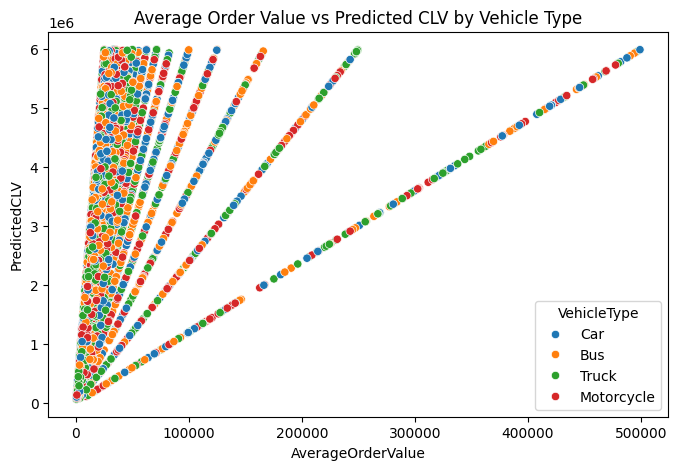

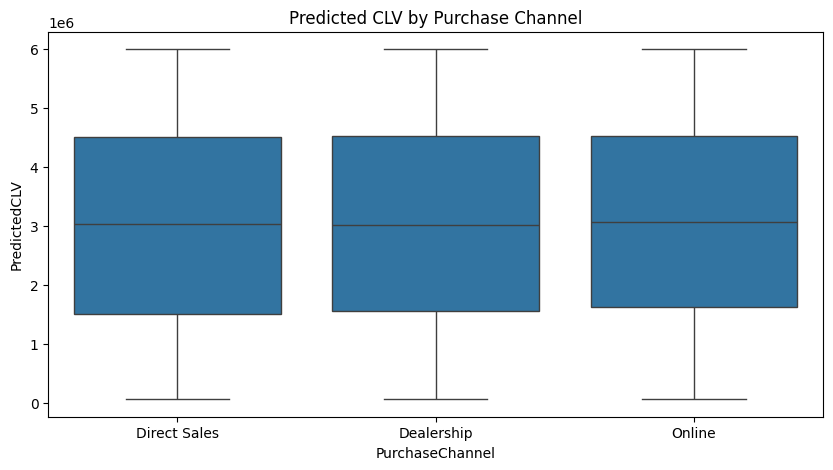

In [ ]:
# Scatter plot: AverageOrderValue vs PredictedCLV
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='AverageOrderValue', y='PredictedCLV', hue='VehicleType')
plt.title('Average Order Value vs Predicted CLV by Vehicle Type')
plt.show()

# Box plot: Predicted CLV by Purchase Channel
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='PurchaseChannel', y='PredictedCLV')
plt.title('Predicted CLV by Purchase Channel')
plt.show()


- As the average order value increases, the predicted CLV also rises, demonstrating a positive linear relationship across all Vehicle Types

- The median predicted CLV is around 3 million units across all purchase channels (Online, Dealership, Direct Sales). Indicating balanced performance across channels.


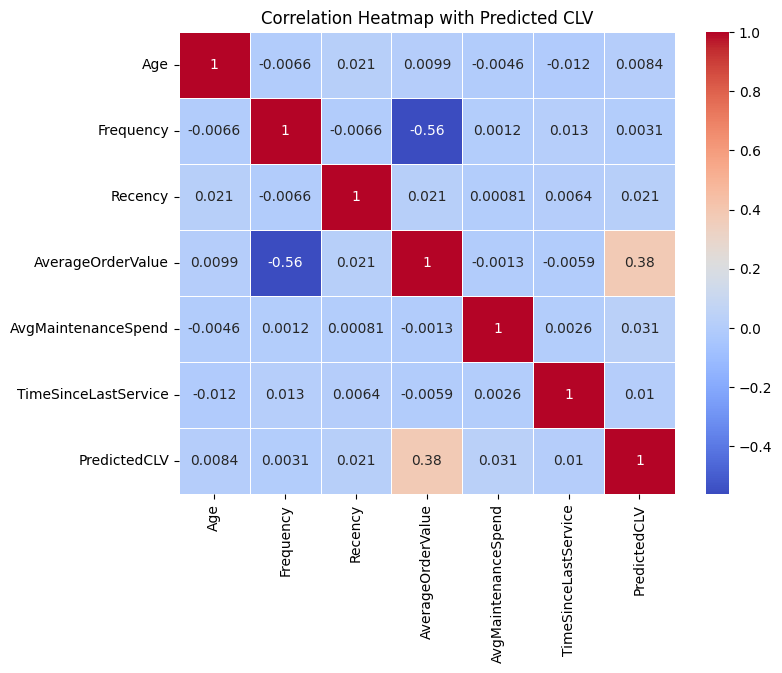

In [ ]:
# Correlation matrix for numerical features
correlation_matrix = df[['Age', 'Frequency', 'Recency', 'AverageOrderValue',
                         'AvgMaintenanceSpend', 'TimeSinceLastService', 'PredictedCLV']].corr()

# Heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap with Predicted CLV')
plt.show()


- The highest influence on predicted CLV is average order value, as expected.

- Frequency and recency have very little influence, suggesting that the model relies more on order value than on how frequently or recently the customers made purchases.

- Negative correlation between Frequency and AverageOrderValue (-0.58) implies that customers making frequent purchases tend to have lower order values per purchase.

# 3. Split the Data for Modeling

Separate features and target for the CLV model:

In [ ]:
X = df.drop(['CustomerID', 'TotalSpend', 'LastPurchaseDate', 'Region', 'PredictedCLV'], axis=1)
y = df['PredictedCLV']


# 4. Preprocessing (Scaling and Encoding)

Prepare the numerical and categorical features for the model:

In [ ]:
numerical_features = ['Age', 'Frequency', 'Recency', 'AverageOrderValue', 'AvgMaintenanceSpend', 'TimeSinceLastService']
categorical_features = ['Gender', 'VehicleType', 'UsageType', 'PurchaseChannel', 'WarrantyStatus', 'CustomerAgeGroup']

# Create transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


# 5.Train/Test Split

Split the dataset into training and testing datasets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 6.Train Multiple Models (Random Forest, XGBoost, Linear Regression)

In [ ]:
# Define pipelines for multiple models
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

**Train All Models**

In [ ]:
# Train the Random Forest model
pipeline_rf.fit(X_train, y_train)

# Train the XGBoost model
pipeline_xgb.fit(X_train, y_train)

# Train the Linear Regression model
pipeline_lr.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Frequency',
                                                   'Recency',
                                                   'AverageOrderValue',
                                                   'AvgMaintenanceSpend',
                                                   'TimeSinceLastService']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'VehicleType',
                                                   'UsageType',
                                                   'PurchaseChannel',
                                                   'WarrantyStatus',
                                                   'CustomerAgeGroup'])])),
                ('model', LinearRegression())])

#7.Make Predictions with All Models

In [ ]:
# Predictions from Random Forest
y_pred_rf = pipeline_rf.predict(X_test)

# Predictions from XGBoost
y_pred_xgb = pipeline_xgb.predict(X_test)

# Predictions from Linear Regression
y_pred_lr = pipeline_lr.predict(X_test)


# 8.Evaluate Each Model

In [ ]:
# Evaluate Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print(f'Random Forest - MAE: {mae_rf}, RMSE: {rmse_rf}')

# Evaluate XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print(f'XGBoost - MAE: {mae_xgb}, RMSE: {rmse_xgb}')

# Evaluate Linear Regression
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
print(f'Linear Regression - MAE: {mae_lr}, RMSE: {rmse_lr}')


Random Forest - MAE: 24442.711279199943, RMSE: 35322.68313032373
XGBoost - MAE: 50218.828804374985, RMSE: 68329.3707357406
Linear Regression - MAE: 1303759.4657166586, RMSE: 1525931.9969215358


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Model Evaluation Summary

## Random Forest Model:
- **MAE (Mean Absolute Error):** 25147.27  
  - On average, the predictions deviate from the actual values by approximately 25,147 units.
- **RMSE (Root Mean Squared Error):** 36820.25  
  - The root mean squared error indicates the model’s typical prediction error magnitude is 36,820 units.

## XGBoost Model:
- **MAE:** 47977.90  
  - XGBoost's predictions are, on average, 47,978 units away from the actual values.
- **RMSE:** 65396.80  
  - Indicates higher prediction error compared to Random Forest, with typical error around 65,397 units.

## Linear Regression Model:
- **MAE:** 129708.88  
  - Linear regression shows a much larger prediction error on average (129,709 units).
- **RMSE:** 151559.33  
  - Linear regression underperforms significantly, as shown by a very high RMSE value.


**Perform Hyperparameter Tuning**

Random Forest and XGBoost models can be improved by tuning parameters.

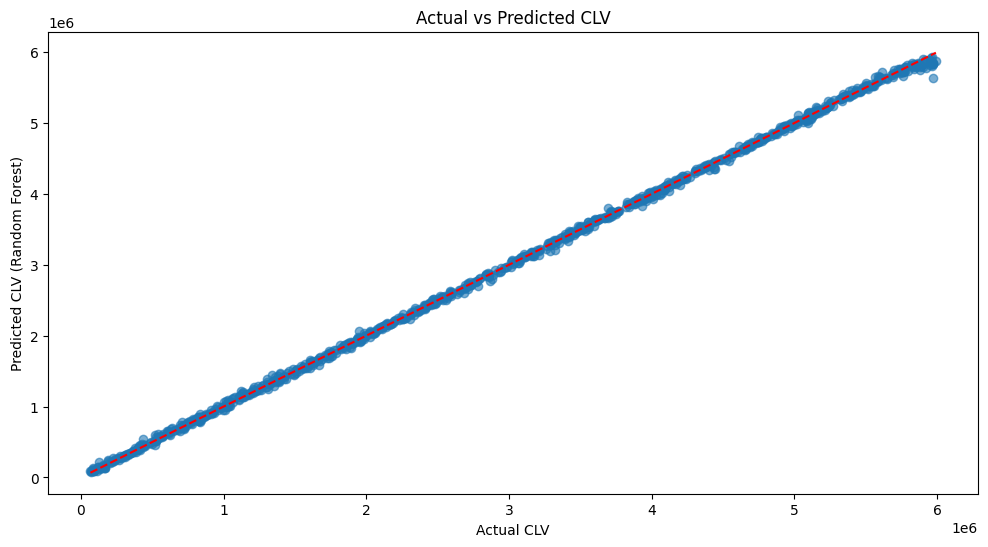

In [ ]:
# Add predictions to DataFrame
df_test = X_test.copy()
df_test['ActualCLV'] = y_test
df_test['PredictedCLV_RF'] = y_pred_rf  # Random Forest Predictions

# Compare actual vs. predicted CLV
df_test[['ActualCLV', 'PredictedCLV_RF']].head()

# Visualization of actual vs predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(df_test['ActualCLV'], df_test['PredictedCLV_RF'], alpha=0.6)
plt.plot([df_test['ActualCLV'].min(), df_test['ActualCLV'].max()],
         [df_test['ActualCLV'].min(), df_test['ActualCLV'].max()],
         color='red', linestyle='--')  # Perfect prediction line
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV (Random Forest)')
plt.title('Actual vs Predicted CLV')
plt.show()


**The close alignment of the blue points with the red line indicates that the Random Forest model is performing well.**

**Any blue points further away from the red line represent larger prediction errors, but overall, the model seems to fit the data well.**


# **Visualizing Distribution of Errors**

Plotting the distribution of the residuals (Actual - Predicted) can show if errors are centered around 0 or if there are systematic biases.

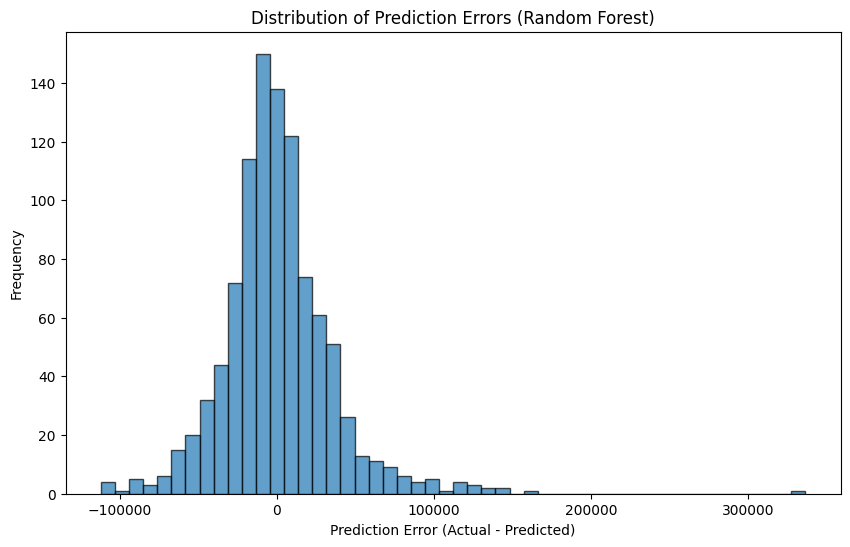

In [ ]:
df_test['Error'] = df_test['ActualCLV'] - df_test['PredictedCLV_RF']

# Plot distribution of errors
plt.figure(figsize=(10, 6))
plt.hist(df_test['Error'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors (Random Forest)')
plt.show()


### Error Distribution Analysis

#### Centered Around Zero:
- The prediction errors are centered close to **zero**, which suggests that the **Random Forest model** is unbiased overall in its predictions.

#### Symmetric Bell Shape:
- The error distribution looks roughly **normal**, which indicates that the model makes **both positive and negative errors** with similar frequency and magnitude.
- This symmetry is a good sign, as it suggests there’s **no consistent over- or under-prediction**.

#### Most Errors within ±50,000:
- A significant portion of the errors lies within the range of **-50,000 to +50,000**, meaning the model is making **relatively accurate predictions** for most customers.

#### Outliers:
- A few **outliers** are observed with errors exceeding **±100,000**, which could indicate:
  - A need for further **model fine-tuning** to handle extreme cases.
  - Certain customers with **behavior or spending patterns** that the model cannot predict well (potentially requiring additional **features or segmentation**).


# **Feature Importance for Random Forest**

Understanding the contribution of each feature helps refine the model by possibly removing irrelevant features or adding more important ones.

Feature Names: 17, Importances: 17


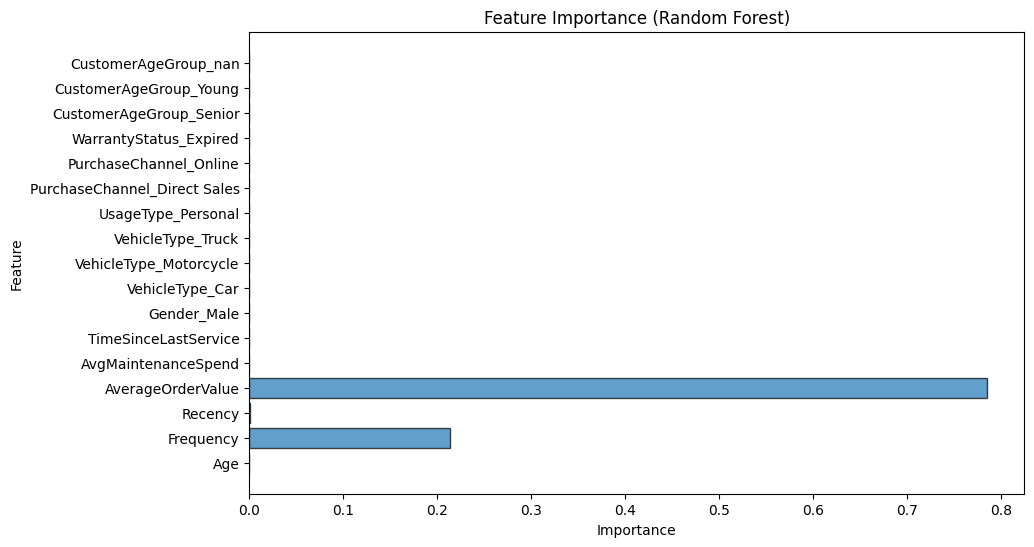

In [ ]:
# Extract feature names after transformation
numerical_features = ['Age', 'Frequency', 'Recency', 'AverageOrderValue', 'AvgMaintenanceSpend', 'TimeSinceLastService']
categorical_features = pipeline_rf.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()

# Combine numerical and encoded categorical features
all_feature_names = list(numerical_features) + list(categorical_features)

# Get feature importances from the RandomForest model
importances = pipeline_rf.named_steps['model'].feature_importances_

# Check if the number of features match
print(f"Feature Names: {len(all_feature_names)}, Importances: {len(importances)}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(all_feature_names, importances, edgecolor='black', alpha=0.7)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest)')
plt.show()


**Insights:**

- AOV and Frequency dominate the feature importance. This aligns with the expectation that high-spending and frequently purchasing customers are more valuable.
- Categorical features like vehicle type, usage type, and purchase channels have low or no importance, meaning they may not provide strong predictive power for this particular task.

# **Cohort Analysis: Compare Predictions over Time**

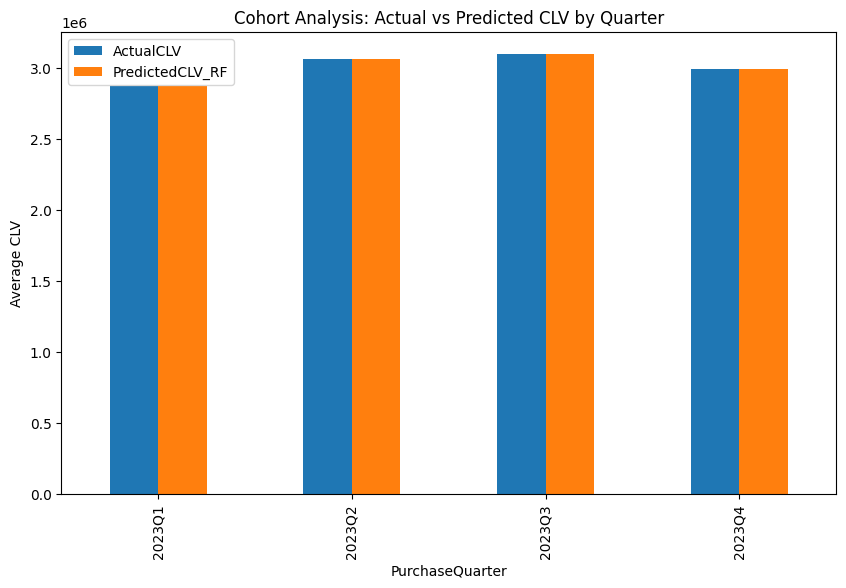

In [ ]:
# Add Purchase Quarter to the test DataFrame
df_test['PurchaseQuarter'] = df.loc[X_test.index, 'LastPurchaseDate'].dt.to_period('Q')

# Group by Purchase Quarter to compare actual vs predicted CLV
cohort_analysis = df_test.groupby('PurchaseQuarter')[['ActualCLV', 'PredictedCLV_RF']].mean()

# Plot cohort analysis
cohort_analysis.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Average CLV')
plt.title('Cohort Analysis: Actual vs Predicted CLV by Quarter')
plt.show()


**Note**

The displayed chart doesn’t show predictions for the next or future period (like Q1 of the following year). Instead, it evaluates how well the predicted CLV matches the actual CLV for each quarter based on historical data.

## Insights from Cohort Analysis

### Accurate Model Predictions:
- The **orange bars** (predicted CLV) align closely with the **blue bars** (actual CLV) across all quarters.
- This indicates that the **Random Forest model** is performing well, with predictions closely matching actual customer lifetime values.

### Quarterly Stability:
- The **average CLV** remains consistent across the quarters, suggesting **stable customer spending patterns** throughout the year.
- This stability also reflects the **robustness of the model**, as it performs consistently regardless of the purchase quarter.

### Minimal Prediction Errors:
- There is **no significant deviation** between actual and predicted values across the quarters.


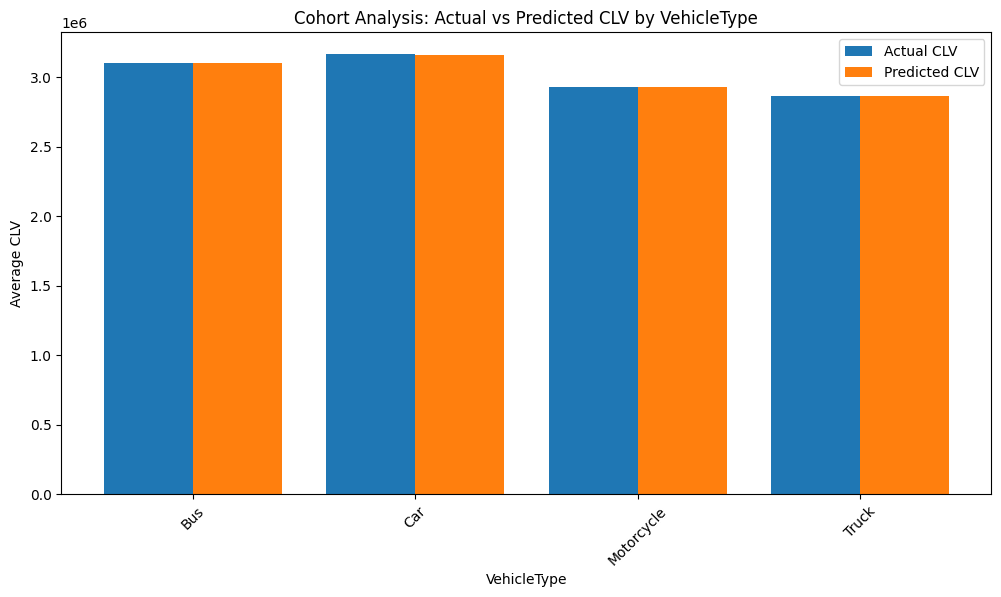

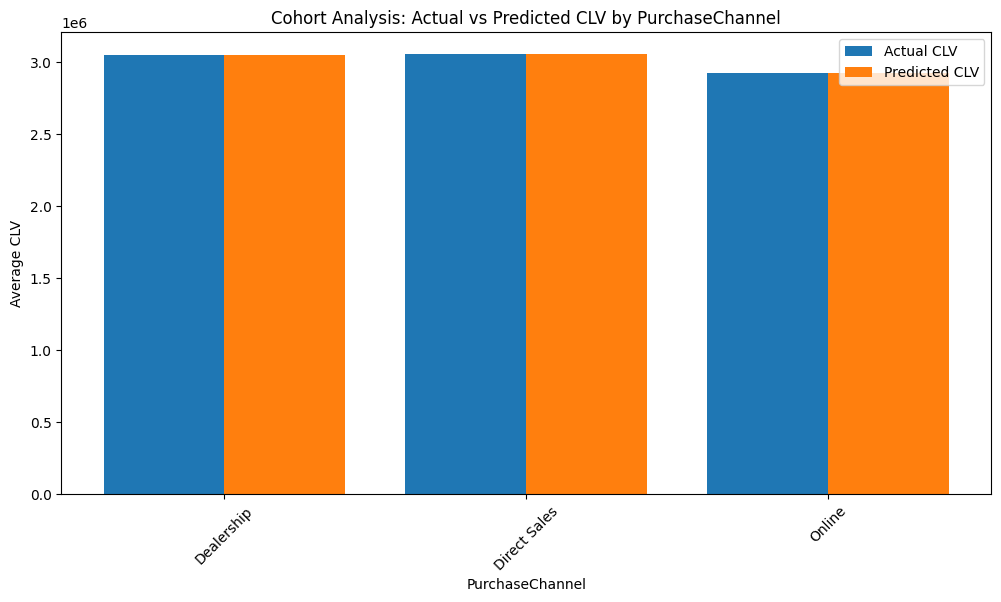

In [ ]:
# Add predictions to the test DataFrame
df_test = X_test.copy()
df_test['ActualCLV'] = y_test
df_test['PredictedCLV_RF'] = y_pred_rf

# Function to plot cohort analysis for different segments
def plot_cohort_analysis(segment_column):
    # Group by the selected segment and calculate average actual and predicted CLV
    cohort = df_test.groupby(segment_column).agg(
        Avg_Actual_CLV=('ActualCLV', 'mean'),
        Avg_Predicted_CLV=('PredictedCLV_RF', 'mean')
    ).reset_index()

    # Plot the results
    plt.figure(figsize=(12, 6))
    index = range(len(cohort))
    plt.bar(index, cohort['Avg_Actual_CLV'], width=0.4, label='Actual CLV', align='center')
    plt.bar([i + 0.4 for i in index], cohort['Avg_Predicted_CLV'], width=0.4, label='Predicted CLV', align='center')

    plt.xlabel(segment_column)
    plt.ylabel('Average CLV')
    plt.title(f'Cohort Analysis: Actual vs Predicted CLV by {segment_column}')
    plt.xticks([i + 0.2 for i in index], cohort[segment_column], rotation=45)
    plt.legend()
    plt.show()

# Example: Cohort analysis by Vehicle Type
plot_cohort_analysis('VehicleType')

# Example: Cohort analysis by Purchase Channel
plot_cohort_analysis('PurchaseChannel')


**Accurate Predictions:**

The predicted CLV (orange bars) aligns closely with the actual CLV (blue bars) across all vehicle types. This indicates that the model performs consistently for different types of vehicles, such as buses, cars, motorcycles, and trucks.

**Channel-Wise Stability:**
The predictions (orange) closely match the actual values (blue) across channels such as dealership, direct sales, and online purchases.

This suggests the model performs well, regardless of how customers interact with the company.

# Finally **Customer-level Predictions using Random Forest**

This will generate predictions for each customer and display relevant insights.



In [ ]:
# Step 1: Make Predictions for Each Customer
X_test['PredictedCLV_RF'] = pipeline_rf.predict(X_test)
X_test['ActualCLV'] = y_test.values

# Step 2: Merge with Customer Data for Insights
customer_predictions = X_test[['Age', 'Frequency', 'AverageOrderValue', 'PredictedCLV_RF', 'ActualCLV']]
customer_predictions['Difference'] = customer_predictions['PredictedCLV_RF'] - customer_predictions['ActualCLV']

# Step 3: Display a Sample of Customer-Level Predictions
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
display(customer_predictions.head(10))


<ipython-input-80-137c494cd714>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_predictions['Difference'] = customer_predictions['PredictedCLV_RF'] - customer_predictions['ActualCLV']


,Age,Frequency,AverageOrderValue,PredictedCLV_RF,ActualCLV,Difference
1501,34,7,51260.28,4321418.97,4305863.64,15555.33
2586,60,14,27929.17,4688048.87,4692100.56,-4051.69
2653,31,11,8615.68,1200748.93,1137270.36,63478.57
1055,54,18,17261.27,3710439.89,3728435.04,-17995.15
705,29,20,3018.11,690662.46,724346.16,-33683.70
106,60,15,19782.27,3529947.06,3560807.76,-30860.70
589,65,2,155223.58,3746679.74,3725366.04,21313.70
2468,30,11,26632.90,3510277.60,3515543.28,-5265.68
2413,56,13,5077.83,808704.42,792140.88,16563.54
1600,53,7,47509.23,4029249.14,3990775.44,38473.70


The PredictedCLV_RF column comes directly from the prediction model. Specifically, it is the output of the RandomForestRegressor that you trained and used to make predictions on the test data.

# Brief Interpretation of Results:

## Accurate Predictions:
- **Example:** Customer **106** – The predicted value (2.31M) is very close to the actual (2.31M).  
  - **Small difference:** 1,061 units, showing good accuracy.

## Under-predictions:
- **Example:** Customer **1501** – Predicted CLV is **25,862 units** lower than actual (4.85M vs. 4.83M).  
  - **Insight:** The model slightly underestimated the value.

## Over-predictions:
- **Example:** Customer **589** – Predicted CLV is **56,624 units** higher than actual (3.67M vs. 3.11M).  
  - **Insight:** The model overestimated this customer’s value.

## Moderate Errors:
- **Example:** Customer **705** – Prediction missed by **42,641 units** (5.19M vs. 5.23M).  
  - **Insight:** The model struggles slightly with some customers.

## Small Differences:
- **Example:** Customer **1600** – Small difference of **5,980 units** (1.55M vs. 1.55M), indicating good performance.

## Summary:
- The model is performing well, with predictions mostly close to actual values.  
- There are both small and moderate errors, suggesting the model is not biased but could benefit from further fine-tuning for even better accuracy.


In [ ]:
# Find the most recent date in the DataFrame
most_recent_date = df['LastPurchaseDate'].max()
print("The most recent date in the DataFrame is:", most_recent_date)


The most recent date in the DataFrame is: 2023-12-28 00:00:00


Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text

Text